<a href="https://colab.research.google.com/github/fortune-max/M4-final-hand-gesture-recognition/blob/main/recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p pretrained_models
!wget https://n-ws-620xz-pd11.s3pd11.sbercloud.ru/b-ws-620xz-pd11-jux/hagrid/hagrid_models_new/RetinaNet_ResNet50.pth -O pretrained_models/RetinaNet_ResNet50.pth

In [76]:
import torch
from models.detectors.retinanet import RetinaNet_ResNet50

model = RetinaNet_ResNet50(
    num_classes=20,
    pretrained=False,
    img_mean=[0.54, 0.499, 0.473],
    img_std=[0.231, 0.232, 0.229],
    img_size=224
)
model.type = "detector"
model_state = torch.load("pretrained_models/RetinaNet_ResNet50.pth", map_location=torch.device('cpu'))["MODEL_STATE"]
model.load_state_dict(model_state)
model.eval()

In [93]:
model_state.keys()

odict_keys(['backbone.body.conv1.weight', 'backbone.body.bn1.weight', 'backbone.body.bn1.bias', 'backbone.body.bn1.running_mean', 'backbone.body.bn1.running_var', 'backbone.body.bn1.num_batches_tracked', 'backbone.body.layer1.0.conv1.weight', 'backbone.body.layer1.0.bn1.weight', 'backbone.body.layer1.0.bn1.bias', 'backbone.body.layer1.0.bn1.running_mean', 'backbone.body.layer1.0.bn1.running_var', 'backbone.body.layer1.0.bn1.num_batches_tracked', 'backbone.body.layer1.0.conv2.weight', 'backbone.body.layer1.0.bn2.weight', 'backbone.body.layer1.0.bn2.bias', 'backbone.body.layer1.0.bn2.running_mean', 'backbone.body.layer1.0.bn2.running_var', 'backbone.body.layer1.0.bn2.num_batches_tracked', 'backbone.body.layer1.0.conv3.weight', 'backbone.body.layer1.0.bn3.weight', 'backbone.body.layer1.0.bn3.bias', 'backbone.body.layer1.0.bn3.running_mean', 'backbone.body.layer1.0.bn3.running_var', 'backbone.body.layer1.0.bn3.num_batches_tracked', 'backbone.body.layer1.0.downsample.0.weight', 'backbone.bo

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.LongestMaxSize(max_size=224, p=1),
    A.PadIfNeeded(min_height=224, min_width=224, value=[144, 144, 144], border_mode=0, p=1),
    ToTensorV2()
])

In [79]:
targets = ["call", "dislike", "fist", "four", "like", "mute", "ok", "one", "palm", "peace", "rock", "stop", "stop inverted", "three", "two up", "two up inverted", "three2", "peace inverted", "no gesture"]

In [178]:
import cv2
from time import time
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

cam = cv2.VideoCapture(0)

def get_img_from_camera():
    ret, frame = cam.read()
    if ret: return frame

def get_imgs_as_stream():
    while True:
        yield get_img_from_camera()

def close_camera():
    cam.release()

def open_camera():
    cam.open(0)

def get_img_from_file(path):
    return cv2.imread(path)

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed_image = transform(image=img)
    processed_image = transformed_image["image"] / 255.0
    return processed_image

def permute_processed_image(img):
    return img.permute(1, 2, 0)

1 found
Gesture: like, confidence: 0.9970441460609436


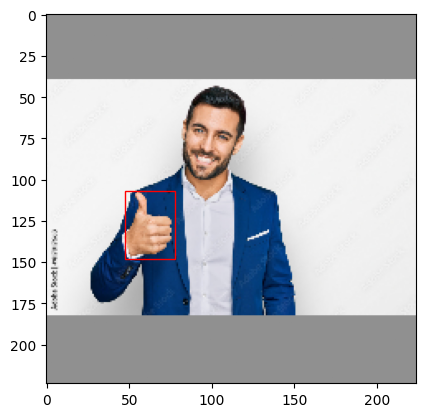

In [160]:
def detect_hands_from_image(path=None, min_num_hands=1):
    frame = get_img_from_file(path or "sample_images/thumbs_2.jpg")
    processed_image = preprocess_image(frame)

    with torch.no_grad():
        output = model([processed_image])[0]
    print(len(output["boxes"]), "found")
    fig, ax = plt.subplots(1)
    ax.imshow(permute_processed_image(processed_image))
    for (box, score, label) in list(zip(output["boxes"], output["scores"], output["labels"]))[:min_num_hands]:
        ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none'))
        print(f"Gesture: {targets[label.item()]}, confidence: {score.item()}")
    plt.show()
detect_hands_from_image()

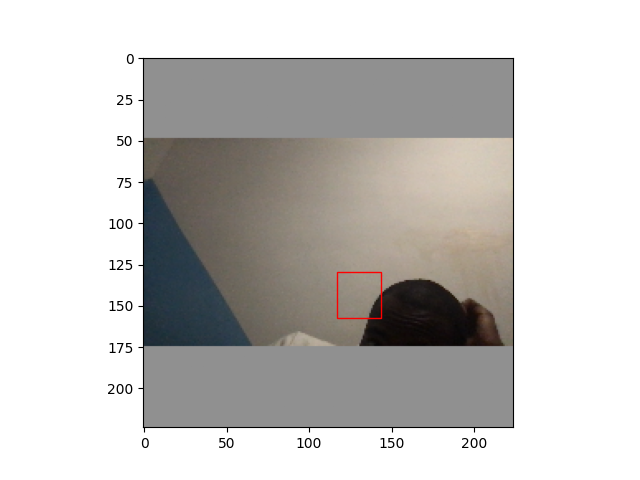

In [ ]:
%matplotlib ipympl

def detect_hands_from_camera(min_num_hands=1):
    cnt = 0
    fig, ax = plt.subplots(1)
    plt.ion()
    while cnt < 10:
        frame = next(get_imgs_as_stream())
        processed_image = preprocess_image(frame)
        ax.clear()

        with torch.no_grad():
            output = model([processed_image])[0]
        # print(len(output["boxes"]), "found")
        ax.imshow(permute_processed_image(processed_image))
        for (box, score, label) in list(zip(output["boxes"], output["scores"], output["labels"]))[:min_num_hands]:
            ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none'))
            # print(f"Gesture: {targets[label.item()]}, confidence: {score.item()}")
        
        plt.show()
        plt.pause(0.001)
        cnt += 1

detect_hands_from_camera()

In [ ]:
close_camera()

In [202]:
open_camera()